## File structure
>WORKSPACE_DIR(.)
>>PRJ_NAME.ipynb  
>>PRJ_NAME_get_data.ipynb  
>>PRJ_NAME_train_model.ipynb   
>>DATA_PATH(datasets)  
>>>PRJ_NAME  
>>>>TRAIN_DIR(train)  
>>>>>CLASS_1_DIR  
>>>>>CLASS_n_DIR  

>>>>VALIDATION_DIR(validation)  
>>>>>CLASS_1_DIR  
>>>>>CLASS_n_DIR  

>>>>TEST_DIR(test)
>>>>>CLASS_1_DIR  
>>>>>CLASS_n_DIR  

>>MODEL_PATH(models)  
>>>PRJ_NAME  

>>Image_PATH(images)  
>>>PRJ_NAME  

>>LOG_PATH(logs)  
>>>PRJ_NAME  


In [1]:
import os
import numpy as np
rand_seed=99
# to make this notebook's output stable across runs
np.random.seed(rand_seed)

PRJ_NAME = "face_recognition"

WORKSPACE_DIR = "."
#where to save dataset
DATA_DIR = PRJ_NAME
DATA_PATH = os.path.join( WORKSPACE_DIR,"datasets",DATA_DIR )

#datasets inlcude train data,validation data,test data
TRAIN_DIR = os.path.join( DATA_PATH, 'train' )
VALIDATION_DIR = os.path.join( DATA_PATH, 'validation' )
TEST_DIR = os.path.join( DATA_PATH, 'test' )

#where to save models
MODEL_DIR = PRJ_NAME
MODEL_PATH = os.path.join( WORKSPACE_DIR,"models",MODEL_DIR )

# where to save figures
IMAGE_DIR = PRJ_NAME
IMAGE_PATH = os.path.join( WORKSPACE_DIR,"images",IMAGE_DIR )

#where to save logs
LOG_DIR = PRJ_NAME
LOG_PATH = os.path.join( WORKSPACE_DIR,"logs",LOG_DIR )

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
#preprocess data
train_datagen = ImageDataGenerator(rescale=1./255)

#to augument performence you can use more parameter to generate more data
# train_datagen = ImageDataGenerator(rescale=1./255,
#                                    rotation_range=40,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
#use generator with flow_from_directory
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(100, 100),
    batch_size=20,
    class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(100, 100),
    batch_size=20,
    class_mode='binary')
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(100, 100),
    batch_size=20,
    class_mode='binary')

C:\Users\jarvis\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 776 images belonging to 2 classes.
Found 786 images belonging to 2 classes.
Found 392 images belonging to 2 classes.


In [3]:
from keras.callbacks import ModelCheckpoint,CSVLogger,EarlyStopping
#add some function as callbacks
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.losses.append(logs.get('val_acc'))

call_history = LossHistory()
        
call_checkpointer = ModelCheckpoint(filepath=MODEL_PATH+"/weights.hdf5", verbose=1, save_best_only=True)

call_log = CSVLogger(LOG_PATH+"/log", separator=',', append=False)

call_stop = EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

In [4]:
from keras import layers,models,optimizers
#make your own model use Sequential or Model
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(100,100,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

#compile model
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])
#now train model
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=20,
                              validation_data=validation_generator,
                              callbacks=[call_checkpointer,call_history,call_log,call_stop])

Epoch 1/20
100/100 [==============================] - 76s 758ms/step - loss: 0.0929 - acc: 0.9665 - val_loss: 0.0073 - val_acc: 0.9987

Epoch 00001: val_loss improved from inf to 0.00732, saving model to .\models\face_recognition/weights.hdf5
Epoch 2/20
100/100 [==============================] - 66s 656ms/step - loss: 0.0075 - acc: 0.9975 - val_loss: 0.0078 - val_acc: 0.9962

Epoch 00002: val_loss did not improve


In [7]:
rslt = model.evaluate_generator(test_generator,steps=50)
print(rslt)

[0.013031911658215652, 0.9918699167608246]


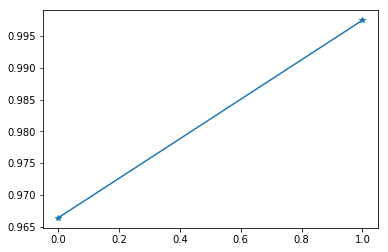

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
log=pd.read_csv(LOG_PATH+"/log")
plt.plot(log['acc'],'*-')